In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

Date range: 2013-10-01 to 2021-01-04
Min 1BTC=$108.58483; Max 1BTC=$33002.53643
Min price occurred on 2013-10-03. Max price occurred on 2021-01-03


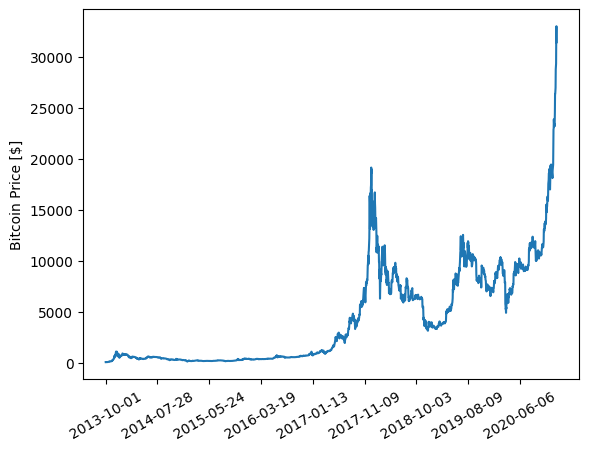

In [17]:
# Load data using pandas
bitcoin_url = 'https://raw.githubusercontent.com/RDeconomist/observatory/main/Bitcoin%20Price.csv'
bitcoin_data = pd.read_csv(bitcoin_url)
date = bitcoin_data['Date']
price = bitcoin_data['Closing Price (USD)'].astype(float)
print(f'Date range: {date.iloc[0]} to {date.iloc[-1]}')
print(f'Min 1BTC=${min(price)}; Max 1BTC=${max(price)}')
print(f'Min price occurred on {date[price.idxmin()]}. Max price occurred on {date[price.idxmax()]}')

plt.plot(price)
plt.ylabel('Bitcoin Price [$]')
plt.xticks(range(0, len(date), 300), date.iloc[::300], rotation=30)
plt.show()

In [32]:
class TimeSeriesDataset(keras.utils.Sequence):
    def __init__(self, time_series, sequence_length):
        self.time_series = time_series
        self.sequence_length = sequence_length
        self._index = 0
    def __len__(self):
        return len(self.time_series) - self.sequence_length


    def __getitem__(self, idx):
        sequence = self.time_series[idx : idx + self.sequence_length]
        return sequence

    def __call__(self):
        for i in range(self.__len__()):
            yield self.__getitem__(i)


print('=== Dataset ===')
dataset = TimeSeriesDataset(price, 30)
t_idx = date.index[date == "2017-12-01"][0]

print(f"Prices starting on {date[t_idx]}:\n ", dataset[t_idx])

=== Dataset ===
Prices starting on 2017-12-01:
  1522     9706.10375
1523    10923.20125
1524    10973.54375
1525    11382.20875
1526    11597.23125
1527    12230.36500
1528    13734.52000
1529    16403.42125
1530    15732.10000
1531    13152.52875
1532    16299.29750
1533    16374.89750
1534    16678.28749
1535    16246.13875
1536    17221.65125
1537    17436.59750
1538    19166.97874
1539    18640.26250
1540    18984.76750
1541    16862.57125
1542    16925.01750
1543    14182.46499
1544    14694.58250
1545    14103.21875
1546    13387.34875
1547    14652.36750
1548    15846.07375
1549    14362.40375
1550    14867.57250
1551    13643.69500
Name: Closing Price (USD), dtype: float64


## Linear Regression
Let's fit a linear regression model to predict the bitcoin price on the 10th day from the previous 9 days.

In [45]:
import time

def loss(pred, y):
    """Mean Absolute Error loss"""
    return tf.reduce_mean(tf.abs(pred - y))

def train(model, loss, dataloader, optimizer):
    total_error = 0.
    for i, sequences in enumerate(dataloader):
        price_history = sequences[i:, i+price_history_len]
        price_now = sequences[:, -1]
        target = sequences[0]

        with tf.GradientTape() as tape:
            pred_now = model.predict(price_history)
            l = loss(pred_now, target)
        total_error += l.numpy()
        grads = tape.gradient(l, model.trainable_variables)

        optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return total_error/i

def fit(model, loss, dataloader, epochs=30):
    optimizer = tf.optimizers.Adam(learning_rate=lr)
    for ep in range(epochs):
        err = train(model, loss, dataloader, optimizer)
        print(f'[Ep{ep} Error {err:.3f}]')

In [46]:
price_history_len = 9
lr = 0.0005
batch_size = 32
epochs = 300

model = keras.Sequential([
    keras.layers.Dense(1, input_shape=(price_history_len,), use_bias=False)
])

dataset = TimeSeriesDataset(price.values, sequence_length=price_history_len + 1)
dataloader = tf.data.Dataset.from_generator(dataset, output_signature=(tf.TensorSpec(shape=(10,), dtype=tf.float32))).batch(batch_size)

In [47]:
fit(model, loss, dataloader, epochs=epochs)

ValueError: in user code:

    File "/Users/admin/GitHub/nn/.venv/lib/python3.9/site-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/Users/admin/GitHub/nn/.venv/lib/python3.9/site-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/admin/GitHub/nn/.venv/lib/python3.9/site-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/admin/GitHub/nn/.venv/lib/python3.9/site-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/Users/admin/GitHub/nn/.venv/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/admin/GitHub/nn/.venv/lib/python3.9/site-packages/keras/src/engine/input_spec.py", line 253, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_3' (type Sequential).
    
    Input 0 of layer "dense_3" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (32,)
    
    Call arguments received by layer 'sequential_3' (type Sequential):
      • inputs=tf.Tensor(shape=(32,), dtype=float32)
      • training=False
      • mask=None


In [50]:
predictions, errors = [], []
for i in range(len(dataset)):
    sequence = dataset[i]
    past, now = dataset[i-2], dataset[i-1]
    pred = dataset[i]
    err = pred - now
    errors.append(err)
    predictions.append(pred)

ValueError: operands could not be broadcast together with shapes (10,) (0,) 

In [ ]:
plt.plot([None] * 9 + predictions, label='prediction')
plt.plot(price, label='ground truth')
plt.ylabel('Bitcoin Price [$]')
plt.xticks(range(0, len(date), 300), date.iloc[::300], rotation=30)
plt.legend()
plt.show()

In [ ]:
plt.hist(np.array(errors), bins=20, edgecolor='black')
plt.xlabel('Error [$]')
plt.ylabel('Frequency')
plt.title('Histogram of Errors')
plt.show()